In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 9)

In [2]:
import pqr

# Предобработка данных

In [3]:
prices = pd.read_excel('factors/russia/monthlyprice.xlsx', index_col=0, parse_dates=True)

mcap = pd.read_excel('factors/russia/mcap.xlsx', index_col=0, parse_dates=True)
pe = pd.read_excel('factors/russia/PE.xlsx', index_col=0, parse_dates=True)
volume = pd.read_excel('factors/russia/betafilter.xlsx', index_col=0, parse_dates=True)

imoex = pd.read_excel('factors/russia/imoex.xlsx', index_col=0, parse_dates=True)

for df in (prices, mcap, pe, volume, imoex):
    df.replace(0, np.nan, inplace=True)

In [4]:
universe = pqr.Universe(prices)
universe.filter(volume >= 10_000_000)

preprocessor = [
    pqr.Filter(universe.mask),
    pqr.LookBackMean(3),
    pqr.Hold(3),
]

size = pqr.Factor(mcap, "less", preprocessor)
value = pqr.Factor(pe, "less", preprocessor)

benchmark = pqr.Benchmark.from_index(imoex["IMOEX"], name="IMOEX")

Сначала строим однофакторные портфели по топ 20%

In [5]:
q02 = pqr.fm.Quantiles(0, 0.2)
size_portfolio = pqr.Portfolio(
    universe, 
    longs=q02(size),
    allocation_strategy=pqr.EqualWeights(),
    name="Size"
)

value_portfolio = pqr.Portfolio(
    universe, 
    longs=q02(value),
    allocation_strategy=pqr.EqualWeights(),
    name="Value"
)

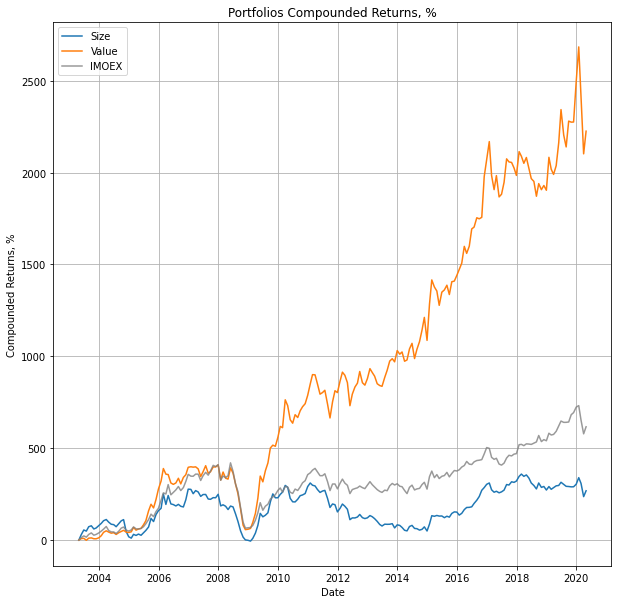

,Size,Value
"Mean Return, %",1.12,1.89
"Volatility, %",9.90,8.34
Sharpe Ratio,0.39,0.78
"Mean Excess Return, %",-1.26,7.96
"Alpha, %",-3.68,7.53
Beta,1.16,1.03


In [6]:
summary = pqr.dash.Dashboard(
    pqr.dash.Graph(pqr.metrics.CompoundedReturns(), benchmark=benchmark),
    pqr.dash.Table(
        pqr.metrics.MeanReturn(annualizer=1),
        pqr.metrics.Volatility(annualizer=1),
        pqr.metrics.SharpeRatio(rf=0),
        pqr.metrics.MeanExcessReturn(benchmark),
        pqr.metrics.Alpha(benchmark),
        pqr.metrics.Beta(benchmark),
    )
)
summary([size_portfolio, value_portfolio])

# Weighted Multifactor

Все просто - сводим мульифакторный выбор к 1-факторному

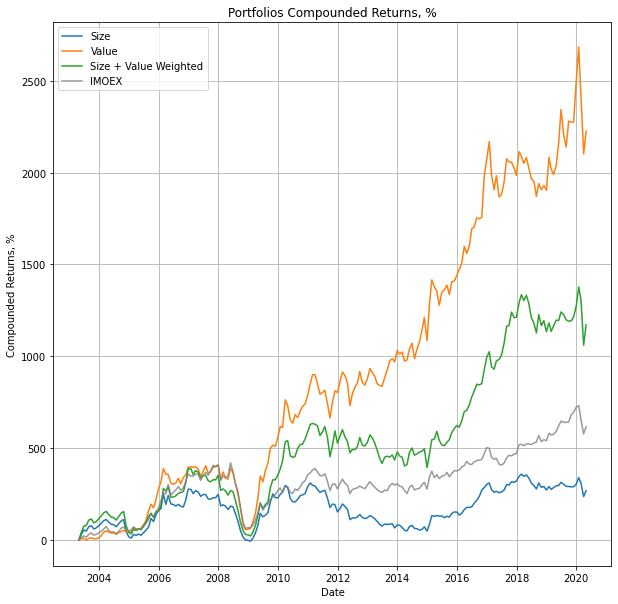

,Size,Value,Size + Value Weighted
"Mean Return, %",1.12,1.89,1.68
"Volatility, %",9.90,8.34,9.43
Sharpe Ratio,0.39,0.78,0.62
"Mean Excess Return, %",-1.26,7.96,5.50
"Alpha, %",-3.68,7.53,4.29
Beta,1.16,1.03,1.08


In [7]:
size_value_weighted = pqr.Factor(
    0.5 * size.values + 0.5 * value.values,
    better="less"
)

size_value_weighted_portfolio = pqr.Portfolio(
    universe,
    longs=q02(size_value_weighted),
    allocation_strategy=pqr.EqualWeights(),
    name="Size + Value Weighted"
)

summary([size_portfolio, value_portfolio, size_value_weighted_portfolio])

# Intercept Multifactor

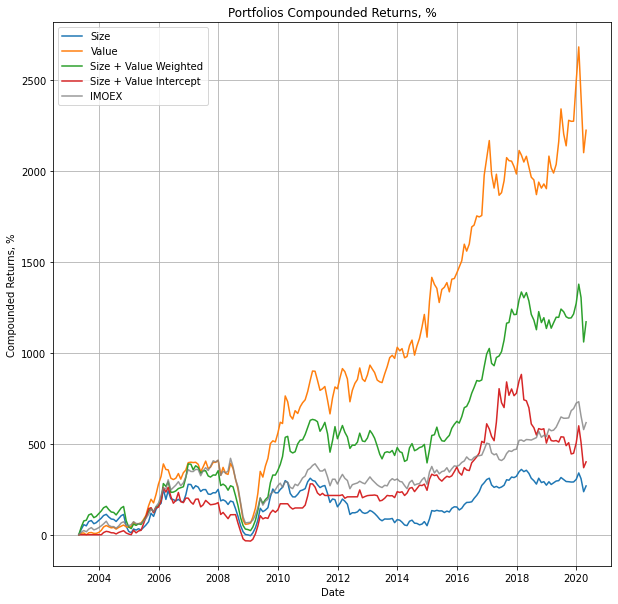

,Size,Value,Size + Value Weighted,Size + Value Intercept
"Mean Return, %",1.12,1.89,1.68,1.29
"Volatility, %",9.90,8.34,9.43,10.23
Sharpe Ratio,0.39,0.78,0.62,0.44
"Mean Excess Return, %",-1.26,7.96,5.50,0.86
"Alpha, %",-3.68,7.53,4.29,1.35
Beta,1.16,1.03,1.08,0.97


In [8]:
size_value_intercept_portfolio = pqr.Portfolio(
    universe,
    longs=q02(size) & q02(value),
    allocation_strategy=pqr.EqualWeights(),
    name="Size + Value Intercept"
)

summary([size_portfolio, value_portfolio, size_value_weighted_portfolio, size_value_intercept_portfolio])

# Double Sort Multifactor

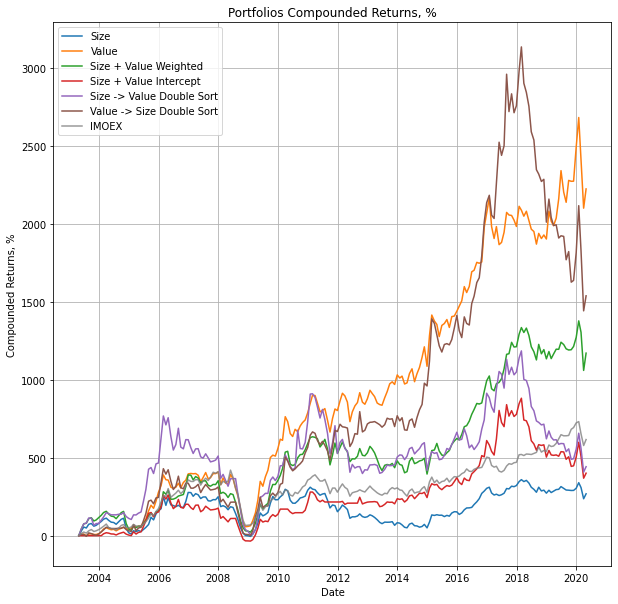

,Size,Value,Size + Value Weighted,Size + Value Intercept,Size -> Value Double Sort,Value -> Size Double Sort
"Mean Return, %",1.12,1.89,1.68,1.29,1.56,1.99
"Volatility, %",9.90,8.34,9.43,10.23,12.49,11.49
Sharpe Ratio,0.39,0.78,0.62,0.44,0.43,0.60
"Mean Excess Return, %",-1.26,7.96,5.50,0.86,4.02,9.18
"Alpha, %",-3.68,7.53,4.29,1.35,0.78,7.45
Beta,1.16,1.03,1.08,0.97,1.22,1.12


In [9]:
size_universe = pqr.Universe(prices)
size_universe.filter(q02(size))

sort_preprocessor_size = [
    pqr.Filter(universe.mask),
    pqr.LookBackMean(3),
    pqr.Hold(3),
    pqr.Filter(size_universe.mask)
]

value_presorted = pqr.Factor(pe, "less", sort_preprocessor_size)

size_value_double_sort_portfolio = pqr.Portfolio(
    universe,
    longs=q02(value_presorted),
    allocation_strategy=pqr.EqualWeights(),
    name="Size -> Value Double Sort"
)


value_universe = pqr.Universe(prices)
value_universe.filter(q02(value))

sort_preprocessor_value = [
    pqr.Filter(universe.mask),
    pqr.LookBackMean(3),
    pqr.Hold(3),
    pqr.Filter(value_universe.mask)
]

size_presorted = pqr.Factor(mcap, "less", sort_preprocessor_value)


value_size_double_sort_portfolio = pqr.Portfolio(
    universe,
    longs=q02(size_presorted),
    allocation_strategy=pqr.EqualWeights(),
    name="Value -> Size Double Sort"
)


summary(
    [
        size_portfolio, value_portfolio, 
         size_value_weighted_portfolio, 
         size_value_intercept_portfolio,
         size_value_double_sort_portfolio,
         value_size_double_sort_portfolio
    ]
)